In [1]:
import glob as gl
import os
import numpy as np
import torch
import matplotlib.pyplot as pl
import matplotlib as mpl
import myutils as mu

In [110]:
def esn_feedback_ana(key,**kwa):

    ### Load accuracy data
    if key=='loadData':
        # kwa needs: modName, expName, dataName
        baseDirName = '/home/jb739/sheffield/proj/esn2sparse/data/'+kwa['modName']+'_'+kwa['expName']
        dirNames = gl.glob(baseDirName+'_*'); dirNames.sort()
        complete = torch.load('/home/jb739/sheffield/proj/esn2sparse/data/'+kwa['modName']+'_'+kwa['expName']+'_0/complete.pt') 
        nLR = complete.shape[0]
        data = []; nRuns = []
        for j,dirName in enumerate(dirNames): # loop over learning rates
            runs = complete[j,:]>0 # Boolean vector of which runs completed
            nRuns.append(np.sum(runs.long().numpy())) # Number of completed runs
            if nRuns[j]>0:  # If there are any runs, do:
                fileNames = gl.glob(dirName+'/'+kwa['dataName']+'*'); fileNames.sort()
                temp = torch.load(fileNames[0])                
                data.append(np.expand_dims(np.array(torch.load(fileNames[0])), axis=1))
                for k in range(1,len(fileNames)): # loop over runs (random seeds)
                    data[j] = np.concatenate((data[j], np.expand_dims(np.array(torch.load(fileNames[k])), axis=1)), axis=1)
            else:
                 data.append([])

        return data
    
    ### Plot accuracies
    if key=='plotAcc':
        # kwa needs: accTr, accVal, saveFlag, figDir, 
        mu.setupMatplotlib()
        accTr = kwa['accTr']
        accVal = kwa['accVal']
        nEpochs = accTr[0].shape[0]
        n = len(accTr)
        colTr1 = np.array(tuple(x**2 for x in (0.,0.3,1.))); colTr2 = np.array(tuple(x**2 for x in (1., 0.5, 0.)))
        print(type(colTr1))
        colVal1 = np.array(tuple(x**2 for x in (0.,1.,0.3))); colVal2 = np.array(tuple(x**2 for x in (0.8, 0., 1.)))
        colShade = np.linspace(0.,1.,n)
        kernel = np.ones(50)/50
        fig = pl.figure(figsize=tuple(np.array((6.,4.))/2.54)); ax = pl.axes()
        ax.spines[['top','right']].set_visible(False)
        for j in range(n):
            colTr = tuple(np.sqrt(colShade[j]**2 * colTr2 + colShade[n-1-j]**2 * colTr1))
            colVal = tuple(np.sqrt(colShade[j]**2 * colVal2 + colShade[n-1-j]**2 * colVal1))
            if np.size(accVal[j])>0:
                # pl.plot(np.linspace(1,nEpochs,nEpochs),np.convolve(np.pad(np.mean(accTr[j],1), (50,50), mode='edge'),kernel,mode='same')[50:-50], linewidth=1.0, color=colTr)
                pl.plot(np.linspace(1,nEpochs,nEpochs),np.convolve(np.pad(np.mean(accVal[j],1), (50,50), mode='edge'),kernel,mode='same')[50:-50], linewidth=1.0, color=colVal)
        ax.xaxis.set_ticks((0,nEpochs)); ax.yaxis.set_ticks((0,1))
        if kwa['saveFlag']:
            mu.checkMakeDir(kwa['figDir'])
            pl.savefig(kwa['figDir']+'/accTrVal.svg', format="svg")
    
    ### Load saved responses
    if key=='loadResp':
        # kwa needs: modName, expName, dataName, selectLR, maxNSeeds, layer
        baseDirName = '/home/jb739/sheffield/proj/esn2sparse/data/'+kwa['modName']+'_'+kwa['expName']+'_*'
        dataDirNames = gl.glob(baseDirName); dataDirNames.sort()
        data = []
        for j,d in enumerate(dataDirNames): # For each learning rate
            if j!=kwa['selectLR']: # For selected best learning rate
                continue
            baseFileName = d+'/'+kwa['dataName']+'*'
            fNames = gl.glob(baseFileName); fNames.sort()
            for f, fName in enumerate(fNames): # For each seed
                if f==kwa['maxNSeeds']: # Only process maxNSeeds seeds
                    break
                # Load response data from fName (1 layer only)
                r = torch.load(fName)[kwa['layer']] 
                # Create new list element for r-data, with shape [#iterations saved, #samples, #neurons x #time steps]
                # data.append(np.reshape(r, (r.shape[0], r.shape[1], r.shape[2]*r.shape[3]))) 
                data.append(r) 

        return data
    
    ### Compute principle components
    if key=='computePCA':
        # kwa needs: data
        from sklearn.decomposition import PCA
        from scipy import stats
        # Preprocess data
        if len(kwa['data'].shape)>3:
            data = kwa['data'][-1,:,:,:]
        else:
            data = kwa['data']
        # for j in range(data.shape[0]):
        #     data[j,:,:] = stats.zscore(data[j,:,:])
        # Init PCA object
        pca = PCA(n_components=100)
        # Perform PCA and return transformed data (last saved time point)
        # p = pca.fit_transform(np.mean(data[-2,:,:]))
        print(np.sum(np.double(np.isnan(data))))
        p = pca.fit_transform(np.mean(data[:,:,-5:], axis=2))
        return p, pca
    
    ### Plot class trajectories and clusters in PCA space
    if key=='plotPCA':
        # kwa needs: data, pca, pc, saveTime, saveFlag, figDir, 
        ### Process inputs
        data = kwa['data'] # Responses
        pca = kwa['pca'] # PCA function
        pc = kwa['pc'] # 1st 2 PCs that define PC space
        var = np.cumsum(np.array(list(x*100 for x in pca.explained_variance_ratio_)))
        if len(kwa['data'].shape)>3:
            nt = data.shape[3]
        else:
            nt = data.shape[2]
        mapData = np.zeros((data.shape[1], 2, nt))
        if len(kwa['data'].shape)>3:
            for t in range(nt):
                mapData[:,:,t] = pca.transform(data[kwa['saveTime'],:,:,t])[:,0:2]
        else:
            for t in range(nt):
                mapData[:,:,t] = pca.transform(data[:,:,t])[:,0:2]
        
        ### Generate figures
        mu.setupMatplotlib()
        # Plot variance explained
        fig = pl.figure(figsize=tuple(np.array((2.,4.))/2.54)); ax = pl.axes()
        ax.spines[['top','right']].set_visible(False)
        pl.scatter(np.linspace(1,100,var.shape[0]), var, s=3,c='k', alpha=0.5)
        pl.plot(np.linspace(1,100,2), np.ones(2)*90, '--', color=(0.5, 0.5, 0.5), linewidth=0.5)
        ax.set_xscale('log')
        # pl.xticks([1,10,100], ['1','10','100'], minor=[2,3,4,5,6,7,8,9,20,30,40,50,60,70,80,90])
        ax.xaxis.set_ticks((1,10,100)); ax.yaxis.set_ticks((0,100))
        ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
        ax.set_xlim(xmin=0.5, xmax=100); ax.set_ylim(ymin=0, ymax=100)
        if kwa['saveFlag']:
            mu.checkMakeDir(kwa['figDir'])
            pl.savefig(kwa['figDir']+'varExplained.svg', format="svg")
        # Plot PCA clusters
        fig = pl.figure(figsize=tuple(np.array((4.,4.))/2.54)); ax = pl.axes()
        ax.spines[['top','right']].set_visible(False)
        for j in range(10):
            col = mpl.colormaps['tab10'].colors[j]
            pl.scatter(pc[j*10:(j+1)*10,0], pc[j*10:(j+1)*10,1], s=3, c=col)
        ax.xaxis.set_ticks((-10,0,10)); ax.yaxis.set_ticks((-10,0,10))
        ax.set_xlim(xmin=-16, xmax=16); ax.set_ylim(ymin=-16, ymax=16)
        if kwa['saveFlag']:
            mu.checkMakeDir(kwa['figDir'])
            pl.savefig(kwa['figDir']+'pcaClusters.svg', format="svg")
        ### Plot mean class response trajectory in PC space
        fig = pl.figure(figsize=tuple(np.array((4.,4.))/2.54)); ax = pl.axes()
        ax.spines[['top','right']].set_visible(False)
        scale = np.logspace(-1,0,nt)
        for j in range(10):
            col = mpl.colormaps['tab10'].colors[j]
            for t in range(mapData.shape[2]-1):
                colT = tuple(x**scale[t] for x in col)
                pl.plot(np.mean(mapData[j*10:(j+1)*10,0,t:t+2], axis=0), np.mean(mapData[j*10:(j+1)*10,1,t:t+2], axis=0), color=colT, linewidth=1)
        ax.xaxis.set_ticks((-10,0,10)); ax.yaxis.set_ticks((-10,0,10))
        ax.set_xlim(xmin=-16, xmax=16); ax.set_ylim(ymin=-16, ymax=16)
        if kwa['saveFlag']:
            mu.checkMakeDir(kwa['figDir'])
            pl.savefig(kwa['figDir']+'pcaTraj.svg', format="svg")
    
    ### Compute clustering index
    if key=='clusterIndex':
        # kwa needs: data
        ### Compute Silhuoette Index
        if len(kwa['data'].shape)>3:
            r = np.mean(kwa['data'][-1,:,:,-5:], axis=2)
        else:
            r = np.mean(kwa['data'][:,:,-5:], axis=2)
        ns = r.shape[0] # No. samples
        nc = 10 # No. clusters
        dist = np.zeros((r.shape[0], r.shape[0]))
        # Compute distances between samples
        for j in range(ns):
            dist[:,j] = np.sqrt(np.sum((r - np.roll(r, -j, axis=0))**2, axis=1))
        # Rearrange dist to yield distance matrix
        # Fill diagonal of dist matrix with NaNs
        for j in range(ns):
            dist[j,:] = np.roll(np.expand_dims(dist[j,:], axis=0), j, axis=1)
            dist[j,j] = np.NaN
        # Compute mean distance from each sample to each cluster
        mDist = np.zeros((ns, nc))
        for j in range(nc):
            mDist[:,j] = np.nanmean(dist[:,j*10:(j+1)*10], axis=1)
        # Rearrange mDist so that each sample's own cluster is in first column
        for j in range(nc):
            mDist[j*10:(j+1)*10,:] = np.roll(mDist[j*10:(j+1)*10,:], -j, axis=1)
        # Calculate Silhuoette Index
        a = np.expand_dims(mDist[:,0], axis=1); b = np.expand_dims(np.min(mDist[:,1:], axis=1), axis=1)
        SI = np.divide(b - a, np.expand_dims(np.max(np.concatenate((a,b), axis=1), axis=1), axis=1))

        return SI
    
    ### Plot cluster indeces
    if key=='plotClusterIndex':
        # kwa needs: ci, figDir, saveFlag
        ci = kwa['ci']
        mu.setupMatplotlib()
        fig = pl.figure(figsize=tuple(np.array((4.,4.))/2.54)); ax = pl.axes()
        ax.spines[['top','right']].set_visible(False)
        for j in range(10):
            col = mpl.colormaps['tab10'].colors[j]
            # pl.plot(np.linspace(j*10+1,(j+1)*10,10), ci[j*10:(j+1)*10], linewidth=1, color=col)
            pl.scatter(np.linspace(j*10+1,(j+1)*10,10), ci[j*10:(j+1)*10], s=3, c=col)
        pl.plot(np.linspace(0,101,2), np.ones(2)*np.mean(ci), '--', color=(0.5, 0.5, 0.5), linewidth=0.5)
        ax.xaxis.set_ticks((1,100)); ax.yaxis.set_ticks((-1,0,1))
        ax.set_xlim(xmin=0, xmax=101); ax.set_ylim(ymin=-1, ymax=1)
        if kwa['saveFlag']:
            mu.checkMakeDir(kwa['figDir'])
            pl.savefig(kwa['figDir']+'clusterIndex.svg', format="svg")

    ### Plot mean cluster indeces across runs for all models
    if key=='allSI':
        # kwa needs: prefix
        # Load data and compute silhouette indeces
        baseName = '/home/jb739/sheffield/proj/esn2sparse/data/'
        models = ('FB0', 'FB1', 'FB2', 'FB3')
        experiment = 'swLR'
        si = np.zeros((len(models), 5))
        for j, model in enumerate(models):
            dirNames = gl.glob(baseName+kwa['prefix']+model+'_'+experiment+'_*'); dirNames.sort(); print(baseName+kwa['prefix']+model+'_'+experiment+'_*'); dirName = dirNames[6]            
            dataName = 'respSave'
            r = esn_feedback_ana('loadResp',modName=model,expName=experiment,dataName=dataName,selectLR=6,maxNSeeds=5,layer=1)
            for k in range(len(r)):
                si[j,k] = np.mean(esn_feedback_ana('clusterIndex',data=r[k]))

        return si
        
    ### Plot all mean SIs
    if key=='plotAllSI':
        # kwa needs: si, figDir, prefix
        si = kwa['si']
        mSI = np.mean(si,axis=1)
        sSI = np.std(si, axis=1)
        mu.setupMatplotlib()
        fig = pl.figure(figsize=tuple(np.array((4.,4.))/2.54)); ax = pl.axes()
        ax.spines[['top','right']].set_visible(False)
        for j in range(si.shape[0]):
            pl.scatter(j+np.random.uniform(-0.25,0.25,(si.shape[1],1)), si[j,:], c=(0., 0., 0., 0.33), s=3)
        pl.errorbar(list(range(4)), mSI, yerr=sSI, fmt='o', color='k', markersize=3)
        ax.xaxis.set_ticks(list(range(4))); ax.yaxis.set_ticks((-1,0,1))
        ax.set_xlim(xmin=-0.5, xmax=3.5); ax.set_ylim(ymin=-1, ymax=1)
        if kwa['saveFlag']:
            mu.checkMakeDir(kwa['figDir'])
            pl.savefig(kwa['figDir']+'/'+kwa['prefix']+'allSI.svg', format="svg")

    ### Plot delta_w 
    if key=='plotDW':
        # kwa needs: modName, expName, dataName, figDir
        baseDirName = '/home/jb739/sheffield/proj/esn2sparse/data/'+kwa['modName']+'_'+kwa['expName']
        dirNames = gl.glob(baseDirName+'_*'); dirNames.sort()
        complete = torch.load('/home/jb739/sheffield/proj/esn2sparse/data/'+kwa['modName']+'_'+kwa['expName']+'_0/complete.pt') 
        nLR = complete.shape[0]
        dw = []
        dwMean = []
        nRuns = []
        for j in range(nLR): # Loop over learning rates
            runs = complete[j,:]>0         # Boolean vector of which runs completed
            nRuns.append(np.sum(runs.long().numpy()))      # Number of completed runs
            if nRuns[j]>0:  # If there are any runs, do:                
                fileNames = gl.glob(dirNames[j]+'/dw*'); fileNames.sort() # Get run filenames
                dw.append(np.expand_dims(np.array(torch.load(fileNames[0])), axis=1)) # store dw for first complete run
                for k in range(1, nRuns[j]): # for all other completed runs
                    dw[j] = np.concatenate((dw[j], np.expand_dims(np.array(torch.load(fileNames[k])), axis=1)), axis=1) # store dw for completed run k
                dwMean.append(np.mean(dw[j], 1)) # compute time series of mean dw across runs
            else:
                # if no completed runs, append empty arrays
                dw.append([]) 
                dwMean.append([]) 
        
        ### Plot dwMean
        mu.setupMatplotlib()
        fig = pl.figure(figsize=tuple(np.array((4.,6.))/2.54)); ax = pl.axes()
        ax.spines[['top','right']].set_visible(False)
        col1 = np.array(tuple(x**2 for x in (0.,1.,0.3))); col2 = np.array(tuple(x**2 for x in (0.8, 0., 1.)))
        colShade = np.linspace(0.,1.,nLR)
        kernel = np.ones(50)/50
        nIter = dw[0].shape[0]
        for j in range(nLR):
            if nRuns[j]>0:
                col = tuple(np.sqrt(colShade[j]**2 * col2 + colShade[nLR-1-j]**2 * col1))
                pl.plot(np.linspace(1,nIter,nIter),np.convolve(np.pad(dwMean[j], (50,50), mode='edge'),kernel,mode='same')[50:-50], linewidth=1.0, color=col)
        print(np.max(dwMean[6]))
        ax.xaxis.set_ticks((0,nIter)); 
        # ax.set_ylim(ymax=0.01)
        pl.yscale('log')
        if kwa['saveFlag']:
            mu.checkMakeDir(kwa['figDir'])
            pl.savefig(kwa['figDir']+'/dw_vs_time.svg', format="svg")
      
        


        


# Select and run analyses


### Plot training and validation accuracies


<class 'numpy.ndarray'>


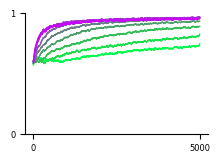

In [83]:
model = 'met_FB0'
experiment = 'swLR'
key = 'loadData'; dataName = 'accTr'
accTr = esn_feedback_ana(key,modName=model,expName=experiment,dataName=dataName)
key = 'loadData'; dataName = 'accVal'
accVal = esn_feedback_ana(key,modName=model,expName=experiment,dataName=dataName)
key = 'plotAcc'; saveFlag = True
esn_feedback_ana(key,accTr=accTr,accVal=accVal,saveFlag=saveFlag, figDir='./figs/'+model+'_'+experiment+'/')

In [65]:
# To estimate which LR to use for further analyses
for i in range(len(accVal)):
    if np.size(accVal[i])>0:
        print(np.max(np.mean(accVal[i][-100:,:], axis=0)))
    else:
        print('None')

0.8059999769926072
0.8941999739408493
0.9347999769449234
0.9577999788522721
0.9701999771595001
0.9755999779701233
0.9755999797582626
0.9709999763965607
None


### Perform PCA and clustering analyses on final hidden layer responses

0.0


/tmp/ipykernel_4884/1986502039.py:133: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  pl.scatter(pc[j*10:(j+1)*10,0], pc[j*10:(j+1)*10,1], s=3, c=col)
/tmp/ipykernel_4884/1986502039.py:196: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  pl.scatter(np.linspace(j*10+1,(j+1)*10,10), ci[j*10:(j+1)*10], s=3, c=col)


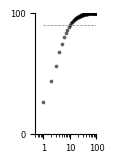

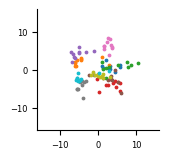

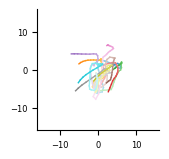

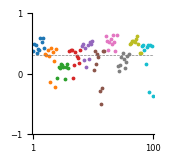

In [117]:
### Plot response examples
saveFlag=True
# Load data
model = 'met_FB0'; experiment = 'swLR'; key = 'loadResp'; dataName = 'respSave11113'
r = esn_feedback_ana(key,modName=model,expName=experiment,dataName=dataName,selectLR=6,maxNSeeds=1,layer=1)
# Compute principle components
key = 'computePCA'
p, *pca = esn_feedback_ana(key,data=r[0])
# Plot PCs
key = 'plotPCA'
esn_feedback_ana(key,data=r[0], pca=pca[0], pc=p, saveTime=-1, saveFlag=saveFlag, figDir='./figs/'+model+'_'+experiment+'/')
# Compute Clustering Index
key = 'clusterIndex'
SI = esn_feedback_ana(key,data=r[0])
# Plot cluster indeces
key = 'plotClusterIndex'; figDir = './figs/'+model+'_'+experiment+'/'
esn_feedback_ana(key, ci=SI, figDir=figDir, saveFlag=saveFlag)
# Plot mean SI across runs for all models
key = 'plotMeanSI'; 
esn_feedback_ana(key)

/home/jb739/sheffield/proj/esn2sparse/data/met_FB0_swLR_*
/home/jb739/sheffield/proj/esn2sparse/data/met_FB1_swLR_*
/home/jb739/sheffield/proj/esn2sparse/data/met_FB2_swLR_*
/home/jb739/sheffield/proj/esn2sparse/data/met_FB3_swLR_*
[[-0.07693752 -0.07434254 -0.01659575 -0.02704032 -0.05293678]
 [-0.03420106 -0.09769985 -0.12098487 -0.01571345 -0.03293838]
 [-0.00914801 -0.05787989  0.03353658 -0.09983352 -0.10257164]
 [-0.05367315  0.002423   -0.05069322 -0.0388067  -0.02663309]]


/tmp/ipykernel_4884/1986502039.py:231: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  pl.scatter(j+np.random.uniform(-0.25,0.25,(si.shape[1],1)), si[j,:], c=(0., 0., 0., 0.33), s=3)


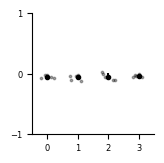

In [112]:
### Plot results summary for all models
key = 'allSI'
si = esn_feedback_ana(key, prefix='met_')
key = 'plotAllSI'; figDir='./figs/swLR'
esn_feedback_ana(key, si=si, figDir=figDir, saveFlag=False)
print(si)


### Plot feedback weight evolution

[ 7.21249671e-05  6.80573061e-02  7.46058524e-02  3.36814821e-02
  2.76330039e-02  3.08635309e-02  3.32895964e-02  5.19827530e-02
  3.19352522e-02  2.02266555e-02  3.15329581e-02 -2.61682123e-02
 -2.48769242e-02 -8.58513862e-02 -2.19985709e-01 -1.35211796e-01
 -1.45491198e-01 -1.03005476e-01 -9.67408791e-02 -1.06082484e-01
 -1.13452770e-01 -7.19642714e-02 -5.53416945e-02 -6.35820329e-02
 -8.25514793e-02  0.00000000e+00]


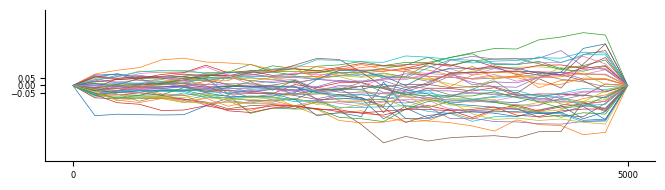

In [103]:
weights=torch.load('/home/jb739/sheffield/proj/esn2sparse/data/met_FB3_swLR_8/weightSave11117.pt')
fig = pl.figure(figsize=tuple(np.array((20.,5.))/2.54)); ax = pl.axes()
ax.spines[['top','right']].set_visible(False)
for j in range(0,1000,100):
    pl.plot(np.linspace(1,5000,26),weights[::2,j,:].transpose(), linewidth=0.5)
ax.xaxis.set_ticks((0,5000)); ax.yaxis.set_ticks((-.05,0,.05)); ax.set_ylim(-.5,.5)
print(weights[0,0,:])

### Plot evolution of mean weight changes

0.00038450677529908715


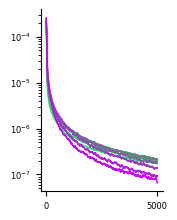

In [111]:
saveFlag = False
key = 'plotDW'; model = 'FB0'; experiment = 'swLR'; dataName = 'respSave11119'
esn_feedback_ana(key, saveFlag=saveFlag, modName=model, expName=experiment, figDir='./figs/'+model+'_'+experiment+'/')